ME 535 Winter 2020

# Homework 2

### Tuesday Feb. 28

Let's start with a problem about dealing with floating point issues.

1a) Consider evaluating the function $f(x) = log(1+x)/x$ near $x=0$. In particular, compute the value at `x = 1e-16`.

In [1]:
import numpy as np

x = 1e-16;
y = np.log(1 + x)/x
y

0.0

The computed result is zero. What is the error associated with this value?
<br> The correct value is very close to 1.0 and the relative error in the value above is close to 100%.

Find an alternative (approximate) expression that is accurate for $|x| << 1$.
<br>Evaluate your alternative expression and estimate the error in the alternative value.

#### log(1+x)/x Discussion
I multiply the small value $x$ by a multiplier $mult$= $10^{n}$ where $n$ $\in$ $[1,10]$ which makes $x$ be not underflow.
And as I increased the value of $mult$, the absolute error get smaller as show in the figures below.

In [2]:
# Serially doing log(1+x)/x and get absolute errors
import numpy as np
def specialLog(x,n):
    """
    return y = log(1+x)/x when x is pretty small even smaller than machine epsilon
    
    Args :
        x : small float, even smaller than machine epsilon
        n : int, equal or greater than 1, order of multiplier (10^n)
    Return :
        y : 1D numpy array of float, log(1+x)/x
        err : 1D numpy array of float, absolute errors, abs(y-1)

    """
    err = np.zeros(n-1)
    y = np.zeros(n-1)
    for i in range(1,n):
        mult = 10**i
        newx = x*mult
        y[i-1] = (np.log(mult+mult*newx)-np.log(mult))/newx
        err[i-1] = abs(y[i-1] - 1)
    return y, err

[0.88817842 0.97699626 1.00364161 1.0000889  0.99991126 1.00000008
 1.00000008 0.99999973 0.99999994]
[1.11821580e-01 2.30037383e-02 3.64161426e-03 8.89005823e-05
 8.87351016e-05 8.27403710e-08 8.27403710e-08 2.72530997e-07
 5.93681762e-08]


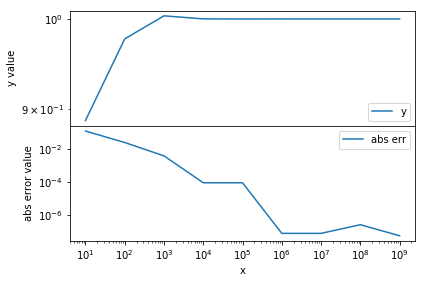

In [3]:
# main part to evaluate my alternative expression of log(1+x)/x
import matplotlib.pyplot as plt
%matplotlib inline 
x = 1e-16
n = 10
y, abs_err = specialLog(x,n)
m = [10**n for n in range(1,n)]

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4])

print(y)
print(abs_err)
ax1.plot(m,y,label = "y value")
ax2.plot(m,abs_err, label = "absolute error")
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.legend(['y'],loc='lower right')
ax2.legend(['abs err'],loc='upper right')
ax2.set_xlabel('x')
ax1.set_ylabel('y value')
ax2.set_ylabel('abs error value')
plt.show()

1b) The usual pythagorean formula for computing the length of the hypotenuse $c = \sqrt{x^2 + y^2}$ (a.k.a. the $L^2$ norm of the displacement vector) is subject to overflow for large input values. The behavior for higher norms (such as $L^{10}$) is even more problematic as illustrated below.

In [4]:
x=1e40
y=1e40
print("(x**10 + y**10)**(1/10) gives ", (x**10+y**10)**(1/10))

OverflowError: (34, 'Result too large')

Provide an alternative version of the formula that avoids the overflow and provides an accurate value.

In [5]:
# function of calculating n order norm avoiding overflow
def N_Order_Norm(x,y,order):
    """
    get rid of overflow problem when doing n order norm, 
    
    Args:
        x :  float value, and x > 1
        y :  float value, and y > 1
        order : int value
    Return:
        res : float number
    """
    if x < 0 or y <0:
        raise NameError("two inputs both must be greater than 0")
    xstr = "{:e}".format(x)
    ystr = "{:e}".format(y)
    xfloat, xsign = xstr.split('e+')
    yfloat, ysign = ystr.split('e+')
    if float(xsign) < 0 or float(ysign) < 0:
        raise NameError("two inputs both must be greater than 1")
    if xsign != ysign:
        if int(xsign) > int(ysign):
            dif = abs(int(xsign) - int(ysign))
            yfloat = float(yfloat)*10**(-dif)
            allfloat = float(yfloat)**order + float(xfloat)**order
            resfloat = allfloat**(1/order)
            resstr = str(resfloat)
            res = float(resstr+'e+'+xsign)
        else:
            xfloat, xsign, yfloat,ysign = yfloat, ysign, xfloat, xsign
            dif = abs(int(xsign) - int(ysign))
            yfloat = float(yfloat)*10**(-dif)
            allfloat = float(yfloat)**order + float(xfloat)**order
            resfloat = allfloat**(1/order)
            resstr = str(resfloat)
            res = float(resstr+'e+'+xsign)
    else:
        allfloat = float(yfloat)**order + float(xfloat)**order
        resfloat = allfloat**(1/order)
        resstr = str(resfloat)
        res = float(resstr+'e+'+xsign)
    return res    

In [6]:
# examine the n order norm function does work
print("(x**10 + y**10)**(1/10) gives ", N_Order_Norm(x,y,10))

(x**10 + y**10)**(1/10) gives  1.0717734625362931e+40


## Now on to some linear algebra...

To avoid starting from scratch, let's put some of our previous code into use. The instructions below walk you through how to save previously created functions for solving linear systems in a file so that the function definitions can be readily imported for re-use.

2a) Write a python function to construct the Vandermonde matrix that arises in the linear system to solve for coefficients in polynomial interpolation. (The matrix should be very similar to an example from class.) 
<br>Your function's input should include an array of input values and an array of corresponding function values and the degree, $n$, of the desired polynomial. 
<br>In general, the number of data points $m$ can be larger than the number of coefficients in the polynomial, but for the remainder of this problem you can make the following specializations:

i) Focus on the case $m=n+1$ that produces a square matrix. 

ii) Choose the input array `x` to consist of $m$ values equally spaced across the unit interval $[0,1]$.

iii) Choose the array of function values so that `y[i] = x[i] + r[i]` where `r` is an array of values selected from a uniform distribution on $[-0.25,0.25]$. (You should use a python library function to generate the random values.)

In [7]:
# 2a) Vandermonde fuction
def van(x,n):
    """
    construct a 2D square numpy Vandermonde matrix 
    
    Args:
        x : 1D numpy array consists of interpolation points
        n : The order of interpolation function
    Return:
        vanMat : 2D numpy array of Vandermonde matrix
    """
    m = n+1
    vanMat = np.zeros(shape=(m,m))
    for i in range(m) :
        for j in range(m) :
            vanMat[i,j] = x[i]**j
    return vanMat

In [8]:
# 2a) function to create data points y with certain variation
def createY(x,r=None):
    y = np.zeros(4)
    if not r:
        r = np.random.uniform(-0.25,0.25,len(x))
    for i in range(len(x)):
        y[i] = x[i] + r[i]
    return y

In [9]:
# 2a) example code
n = 3
m = n+1
x = np.linspace(0,1,m)
y = createY(x)
vanMat = van(x,n)
print('My 4x4 VanderMonde matrix')
print(vanMat)

My 4x4 VanderMonde matrix
[[1.         0.         0.         0.        ]
 [1.         0.33333333 0.11111111 0.03703704]
 [1.         0.66666667 0.44444444 0.2962963 ]
 [1.         1.         1.         1.        ]]


2b) Test out your function for $m=4$. <br>Form the appropriate Vandermonde system and compute the solution using your linear solver code. <br>Plot the input data and the computed degree 3 polynomial. <br>Does your polynomial interpolate the data points?

#### 2b) Discussion #### 
After construction 4x4 Vandermonde matrix and using least square function to get the coefficients of my degree 3 polynomial,
my interpolated points does match the data points.
Code and results as shown below.

D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


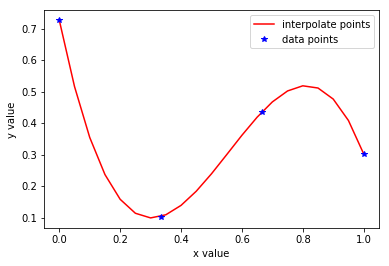

In [12]:
# 2b) test Vandermonde matrix by interpolating points
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
n = 3
m = n+1
x = np.linspace(0,1,m)
y = createY(x)
vanMat = van(x,n)
interpolate_num = 21
start = 0
end = 1
order = 4
x = np.linspace(start, end, m)
y = np.abs( np.random.randn(m))
A = vanMat
cfs,_,_,_ = np.linalg.lstsq(A, y)
interpolate_x = np.linspace(start, end, interpolate_num)
interpolate_y = np.zeros(interpolate_num)
for ind, ix in enumerate(interpolate_x):
    interpolate_y[ind] = np.sum(cfs * ix**np.arange(0, order))
plt.figure()
plt.plot(interpolate_x, interpolate_y, '-r', label='interpolate points')
plt.plot(x, y, '*b', label='data points')
plt.xlabel( 'x value' )
plt.ylabel( 'y value' )
plt.legend(loc='upper right')
plt.show()

2c) Construct Vandermonde matrices of size $m \in [6,12]$, and consider the sensitivity of the results to changes in the data. The relevant "theoretical" result involves the __condition number__: $\kappa(A) = ||A^{-1}||_2 \; ||A||_2$.

$||A||_2$ is the Euclidean matrix norm defined by $||A||_2 = \frac{||A x||_2}{||x||_2}$, but you should not need to code this up. 
<br>Use a function from the numpy linear algebra package. 

Compute this expression for the condition number for each of your Vandermonde matrices, and plot condition number as a function of size.

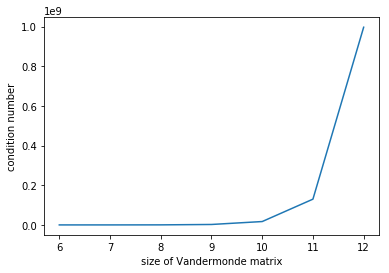

In [13]:
# 2c) theoretical condition number
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline 
start = 6
end = 12
number = end-start+1
m = np.linspace(start, end, number)
theo_conNum = np.zeros(number)
for i in m:
    i = int(i)
    x = np.linspace(0,1,i)
    VanMat = van(x,i-1)
    invVanMat = LA.inv(VanMat)
    theo_conNum[i-start] = LA.norm(VanMat)*LA.norm(invVanMat)
plt.plot(m,theo_conNum)
plt.ylabel('condition number')
plt.xlabel('size of Vandermonde matrix')
plt.show()

2d) For larger problems, computing the matrix inverse can be expensive so we would like to avoid it. The alternative approach is "experimental": quantify how the solution changes as a result of a small change to the input data.

In particular, change the problem by adding a second random component `s[i]` to your function values with `s[i]` uniformly distributed on $[-0.01, 0.01]$. 
<br>Compute the following ratio as a measure of sensitivity: `(norm of change in output) / (norm of change in input)`
<br>Compare the "experimental" sensitivity to the "theoretical" condition number values computed in 2c.

D:\anaconda\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


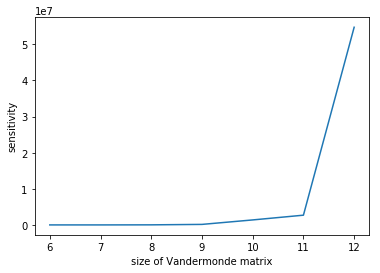

In [14]:
# 2d) experimental sensitivity number
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline 
start = 6
end = 12
number = end-start+1
m = np.linspace(start, end, number)
expe_sensNum = np.zeros(number)
for i in m:
    i = int(i)
    x = np.linspace(0,1,i)
    Y_og = x
    s = np.random.uniform(-0.01,0.01,i)
    
    VanMat = van(x,i-1)
    Y_new = np.add(Y_og,s)
    
    x_og,_,_,_ = np.linalg.lstsq(VanMat, Y_og)
    x_new,_,_,_ = np.linalg.lstsq(VanMat, Y_new)
    
    expe_sensNum[i-start] = np.abs(LA.norm(np.subtract(x_new,x_og))/LA.norm(np.subtract(Y_new,Y_og)))
plt.plot(m,expe_sensNum)
plt.xlabel('size of Vandermonde matrix')
plt.ylabel('sensitivity')
plt.show()

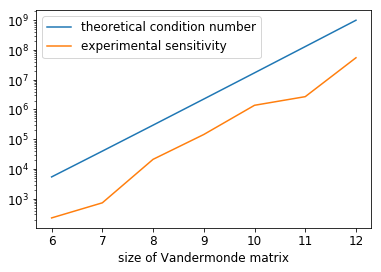

In [15]:
# 2d) comparison of theretical condition number in 2c and experimental sensitivity number in 2d
%matplotlib inline 
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.plot(m,theo_conNum, label = 'theoretical condition number')
plt.plot(m,expe_sensNum,label = 'experimental sensitivity')
plt.xlabel('size of Vandermonde matrix')
plt.legend(loc='upper left')
plt.show()

#### 2d) Discussion
The comparison plot shown above showed that both condition number and sensitivity number share the same trend. When the size of Vandermonde matrix goes up, the condition number and sensitivity rise up which means the matrix is closer to be a singular matrix.

2e) We discussed the "normal equations" that arise when the linear system is pre-multiplied by $A^T$. 
<br>Compute the condition number for normal equations for the same problems considered in 2c. <br>Plot the condition number results. Compare with the results from 2c and discuss the implications.

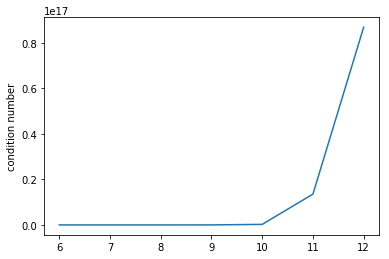

In [21]:
# 2e) use normal equations to compute condition number
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline 
start = 6
end = 12
number = end-start+1
m = np.linspace(start, end, number)
normal_conNum = np.zeros(number)
for i in m:
    i = int(i)
    x = np.linspace(0,1,i)
    VanMat = van(x,i-1)
    VanMat_T = np.transpose(VanMat)
    normal_van = np.dot(VanMat_T,VanMat)
    invnormal_van = np.linalg.inv(normal_van) 
    normal_conNum[i-start] = LA.norm(normal_van)*LA.norm(invnormal_van)
plt.plot(m,normal_conNum)
plt.ylabel('condition number')
plt.show()

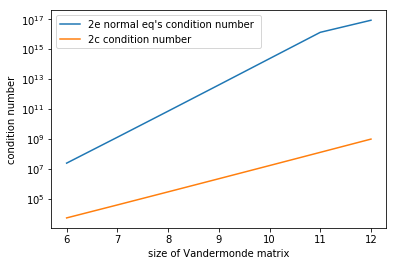

In [22]:
# 2e) compare normal eq's condition number with that of 2c
%matplotlib inline 
plt.plot(m,normal_conNum, label = '2e normal eq\'s condition number ')
plt.plot(m,theo_conNum, label = "2c condition number")
plt.ylabel('condition number')
plt.xlabel('size of Vandermonde matrix')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

#### 2e) Discussion
From the graph above, it shows that order of normal eq's condition number is about twice of that of 2c condition number.
This is quite reasonable since then it is premultiplied by A.T, which means when the smallest number multiplied by itself,  
the order of smallest number is doubled and vice versa.
So the matrix is streched along the longest way, but compressed along the smallest direction and the condition number showed the result.

3) For the 5x5 Vandermonde matrix you constructed in problem 2:

a) Compute the leading eigenvalue (the one with largest magnitude) and the associated eigenvector by matrix iteration.

In [23]:
# 3a) predefine function of power iteration & function of getting the more frequet eigenvalue
import numpy as np
def power_iteration(A, it):
    """
    iteratively get the leading eigenvector
    
    Args:
        A : 2D numpy array of floats, nxn matrix
    Returns:
        b : 1D numpy array of floats, leading eigenvector of A
    """
    b = np.random.rand(A.shape[1])
    for _ in range(it):
        b1 = np.dot(A, b)
        b1_norm = np.linalg.norm(b1)
        b = b1 / b1_norm
    return b

def getEigval(e):
    """
    Given an array of possible eigenvalues with certain amount of floating error, 
    I trucated them to 3 digits precision and pick the one comes most often.
    Since after we get the leading eigenvector x and
    doing multiplication of A*x = lambda*x, and comparing the multiplier of RHS w.r.t LHS elementwisely, 
    there are still some eigenvalues that are close to but not exactly the same one.
    Ex: lambda1 = 4.168989, lambda2 = 4.168899, lambda3 = 4.169009
    Even they are close to each other and we thought the eigenvalue should be 4.169,
    so I need to come up with an approach to take the one comes most often
    
    Args:
        e : 1D numpy array of floats, possible eigenvalues
    Returns:
        result : float, the eigenvalue comes most often.
    
    """
    res = dict()
    for i in e:
        i = float('%.3f'%(i))
        if i not in res:
            res[i] = 1
        else:
            res[i] += 1
    result = max(res.keys(), key=(lambda key: res[key]))
    return result

In [24]:
from numpy import linalg as LA
m = 5
x = np.linspace(0,1,m)
van5 = van(x,m-1)
eigVec = power_iteration(van5, 200)
eigVals = np.true_divide(np.dot(van5,eigVec),eigVec)
maxEigval = getEigval(eigVals)
print('leading eigvec of mine')
print(eigVec)
print()
print('leading eigvalue of mine')
print(maxEigval)


leading eigvec of mine
[3.26212605e-35 1.18506858e-02 8.77005195e-02 3.38909053e-01
 9.36647657e-01]

leading eigvalue of mine
1.468


b) Use iteration to compute the smallest eigenvalue and its associated eigenvector without using the matrix inverse. Explain your approach, and compare the ratio of eigenvalues you obtain to the previously computed condition number.

#### 3b) Procedure
My approach to get smallest eigenvalue and its corresponding eigen vector includes following steps:
1. Creating 5X5 Vandervonde matrix A.
2. Iteratively using LU factorization and reconstruct A   
   $L_{k+1}$$U_{k+1}$ = $A_{k}$  
   $A_{k+1}$ = $U_{k+1}$$L_{k+1}$  
3. After twenty rounds, the diagonal of upper triangular matrix $U_{20}$ consists of all eigenvalues of matrix A. 
4. Get the minimum eigenvalue $\lambda$.
5. Construct singular matirx $A_{\lambda}$ = $A$ - $\lambda$$I$  
6. Using LU decomposition and LU solver on upper left 4x4 matrix of $A_{\lambda}$  to get an 4x1 $x$ vector where $b$ is the negetive one multiply by all the last element of the first four rows (-1 * A[:,4]). (Ax = LUx = Ly = b)
7. Append 1 on the 4x1 $x$ vector to make a 5x1 $x$ eigenvector.
8. Normalized the 5x1 $x$ eigenvector and return this result.

#### 3b) Discussion
After I developed this procedure, I wrapped up for a new function `RatioOfEigvalue` to generate ratio between max eigvalue and min eigvalue serially. After comparing the ratio with condition number from 2c, I found they share the same trend which both showed when size of Vendermonde matrix increase, it becomes worser conditioning.

In [25]:
# 3b) helper function to help get eigenvector from corresponding eigenvalue
from basic_elim import *
def getNontrivialeigvec(A):
    """
    return nontrivial eigenvector given singular matrix A
    
    Args:
        A : 2D numpy array of floats, nxn singular matrix, and A matrix must be (A-eigenvalue*I) already
    
    Return:
        res : 1D numpy array of floats, eigenvector
    """
    m = A.shape[0]
    L,U = LU_factor(A[:(m-1),:(m-1)])
    b = -1*A[:,4]
    smalleigvec,y = LU_solve(L,U,b)
    res = np.append(smalleigvec,1)
    res = res/LA.norm(res)
    return res

In [26]:
# 3b) main part to get smallest eigenvalue and eigen vector
from basic_elim import *
from numpy import linalg as LA
m = 5
x = np.linspace(0,1,m)
van5 = van(x,m-1)

for i in range(20):
    L, U = LU_factor(van5)
    van5 = np.dot(U,L)

smalleigval = np.min(np.diag(U))
van5 = van(x,m-1)
newvan5 = np.subtract(van5, smalleigval*np.identity(m))
smalleigenVec = getNontrivialeigvec(newvan5)
#smalleigenVec = smalleigenVec / LA.norm(smalleigenVec)
print("smallest eigenvalue")
print(smalleigval)
print("eigenvector of corresponding eigenvalue")
print(smalleigenVec)


smallest eigenvalue
0.006177703029577491
eigenvector of corresponding eigenvalue
[-0.         -0.06757968  0.43464172 -0.79053838  0.42610871]


In [27]:
# 3b) Wrap up for generating several ratios of eienvalues
from basic_elim import *
from numpy import linalg as LA
def RatioOfEigvalue(m=None):
    """
    compute the ratio of max eigenvalue and min eigenvalue
    
    Args:
        m : integer, the size of Vendermonde matrix
        
    Return:
        res : ratio of max eigenvalue and min eigenvalue of corresponding Vendermonde matrix
    """
    if not m:
        m = 5
    x = np.linspace(0,1,m)
    van5 = van(x,m-1)

    for i in range(100):
        L, U = LU_factor(van5)
        van5 = np.dot(U,L)

    smalleigval = np.min(np.diag(U))
    van5 = van(x,m-1)
    newvan5 = np.subtract(van5, smalleigval*np.identity(m))
    smalleigenVec = getNontrivialeigvec(newvan5)
    maxEigvec = power_iteration(van5, 200)
    eigVals = np.true_divide(np.dot(van5,maxEigvec),maxEigvec)
    maxEigval = getEigval(eigVals)
    res = maxEigval/smalleigval
    return res

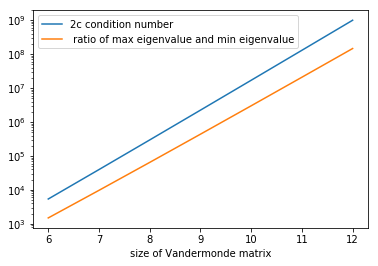

In [28]:
# 3b) compare ratio of eigenvalue to condition number of 2c
%matplotlib inline 
start = 6
end = 12
m = np.linspace(start,end,end-start+1)
eigRatio = np.zeros(end-start+1)
for i in range(start,end+1):
    eigRatio[i-start] = RatioOfEigvalue(i)

plt.plot(m,theo_conNum, label = "2c condition number")
plt.plot(m,eigRatio, label = ' ratio of max eigenvalue and min eigenvalue')
plt.xlabel('size of Vandermonde matrix')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

4a) Write your own python code to implement Gram-Schmidt orthogonalization.

4b) Use your code an orthonormal matrix Q whose columns provide an orthogonal basis for your 4x4 Vandermonde matrix $V_4$.

4c) Check if $Q^T Q = I$.

4d) Compute $Q^T V_4$. Describe your result.

In [29]:
# 4a) Gram-Schmidt function
import numpy as np
from numpy import linalg as LA
def GramSchmidt(X):
    """
    Generate an orthonormal matrix Y, given nxn Vendermonde matrix
    
    Args:
        X : nxn Vendermonde matrix
    Returns:
        Y : nxn orthonormal matrix
    """
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/LA.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    Y = np.diag(1/LA.norm(Y,axis=1)).dot(Y)
    return Y

In [30]:
# 4b) Get an orthonomal matrix Q from 4x4 Vandermonde matrix
m = 4
x = np.linspace(0,1,m)
van4 = van(x,m-1)
Q = GramSchmidt(van4)
print("4x4 orthonormal matrix = ")
print(Q)

4x4 orthonormal matrix = 
[[ 1.          0.          0.          0.        ]
 [ 0.          0.94345635  0.31448545  0.10482848]
 [ 0.         -0.29290566  0.64276519  0.70785534]
 [ 0.          0.15523011 -0.69853547  0.69853547]]


In [31]:
# 4c) check if Q transpose * Q = I
print("Q.T * Q = ")
print(np.dot(Q.T,Q))
print("Norm of Q.T*Q  = ",LA.norm(np.dot(Q.T,Q)))

Q.T * Q = 
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  8.60422844e-16 -1.44328993e-15]
 [ 0.00000000e+00  8.60422844e-16  1.00000000e+00  5.55111512e-17]
 [ 0.00000000e+00 -1.44328993e-15  5.55111512e-17  1.00000000e+00]]
Norm of Q.T*Q  =  2.0


In [32]:
# 4d) Visualize Q.T * van4
print(np.dot(Q.T, van4))

[[ 1.          0.          0.          0.        ]
 [ 0.8057808   0.27444512  0.1298783   0.10338607]
 [ 0.25871517 -0.16519686 -0.37791923 -0.49643892]
 [ 1.5112193   1.20538186  1.02478546  0.91215293]]


#### 4d) Discussion
The $Q.T$*$V_{4}$ is a 4x4 matrix where each row are orthogonal to each other and all their magnitude are 1 which means they are normalized.

## Making your own loadable code library:

In class (and the documents "Ch2_LinearSystems" and "code_LU...") we looked at a basic elimination approach to solving a linear system. 
The essential functions (including your implementation of `lower_tri_solve`) are `LU_factor`, `LU_solve`, `upper_tri_solve`, and `lower_tri_solve`. 

When you have created useful code, you will want to store it in a way that you can conveniently import and use the code you have previously created. Here is a simple way to do that:

    i) From the file menu, select `New=>TextFile`. 

    ii) Save the file as "basic_elim.py"

    iii) Paste into the file the statement to import `numpy` and the definitions of the 4 functions. 

    iv) Save the completed file in the same folder with your notebook. 

You can now import the code from the file with the command below:

In [33]:
from basic_elim import *

Note that `*` indicates that all definitions inthe file should be imported.

Check that the file was loaded by requesting help on one of the functions:

In [34]:
?LU_factor

Signature: LU_factor(A)
Docstring:
solve Lower and upper triangular matrix

Args:
    A : 2D numpy matrix

return:
    L: Lower triangular matrix
    U: Upper triangular matrix
File:      c:\users\yaochungliang\me535\hw2\basic_elim.py
Type:      function
